In [1]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from src.datasets.amass_parser import read_data, get_babel_labels

In [4]:
import joblib
import argparse
from tqdm import tqdm
import json
import os.path as osp
import os
import sys
sys.path.append('.')

import torch
from human_body_prior.tools.omni_tools import copy2cpu as c2c
from human_body_prior.body_model.body_model import BodyModel
from src.datasets import smpl_utils
from src import config
import numpy as np
from PIL import Image

In [5]:
print("Loading Body Models")
body_models = {
    "neutral": BodyModel(
        "/srv/hays-lab/scratch/sanisetty3/music_motion/motion_vqvae/body_models/smplh/neutral/model.npz",
        num_betas=config.NUM_BETAS,
    ).to(device),
}
print("DONE! - Loading Body Models")


Loading Body Models
DONE! - Loading Body Models


In [6]:
clip_images_path = "./render/"

In [7]:
# results_dict = read_single_sequence(
#             "test",
#             "amass",
#             "../HumanML3D/amass_data/ACCAD/",
#             "ACCAD",
#             body_models,
#             20,
#             5,
#             joints_to_use = get_joints_to_use(),
#             quick_run =False,
#             clip_images_path = clip_images_path,
#             fname_to_babel = [""],
#         )

In [8]:
def get_joints_to_use():
    joints_to_use = np.array([
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
        11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 37
    ])  # 23 joints + global_orient # 21 base joints + left_index1(22) + right_index1 (37)
    return np.arange(0, len(smpl_utils.SMPLH_JOINT_NAMES) * 3).reshape((-1, 3))[joints_to_use].reshape(-1)


In [9]:
from src.datasets.amass_parser import read_data, get_babel_labels

In [10]:
fname_to_babel = get_babel_labels("./data/babel_v1.0_release/")

Loading babel labels
DONE! - Loading babel labels


In [6]:
# fname_to_babel['BioMotionLab_NTroje/rub055/0020_lifting_heavy2_poses.npz']

In [7]:
from src.datasets.amass import AMASS
import clip
from PIL import Image
from glob import glob
from src.utils.tensors import collate
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.parser.training import parser, add_training_options
from src.parser.base import add_misc_options, add_cuda_options, adding_cuda, ArgumentParser
from src.parser.dataset import add_dataset_options
from src.parser.model import add_model_options, parse_modelname

In [12]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device, jit=False)  # Must set jit=False for training
clip.model.convert_weights(clip_model)  # Actually this line is unnecessary since clip by default already on float16


In [117]:
cd ../TGM3D/

/coc/scratch/sanisetty3/music_motion/TGM3D


In [121]:
from core.models.motion_clip.motion_clip import MotionClipEncoder

ckpt = torch.load("/srv/hays-lab/scratch/sanisetty3/music_motion/TGM3D/core/models/motion_clip/MotionClipEncoder.pt", map_location="cpu")
enc = MotionClipEncoder().eval().to(device)
enc.load_state_dict(ckpt)

<All keys matched successfully>

In [119]:
cd ../MotionCLIP/

/coc/scratch/sanisetty3/music_motion/MotionCLIP


In [41]:
!python -m src.visualize.text2motion ./exps/paper-model/checkpoint_0100.pth.tar --input_file assets/paper_texts.txt --cuda 

/srv/hays-lab/scratch/sanisetty3/music_motion/MotionCLIP/data/amass_db/amass_30fps_vald.pt
datapath used by amass is [/srv/hays-lab/scratch/sanisetty3/music_motion/MotionCLIP/data/amass_db/amass_30fps_vald.pt]
100
100
Restore weights..
Visualization of the epoch 100
Generate the videos..
Load the generated samples: 100%|#################| 6/6 [00:01<00:00,  4.30it/s]
Stacking frames..
100%|##########################################| 65/65 [00:00<00:00, 249.24it/s]
Writing video [./exps/paper-model/clip_text_paper_texts_fig_100.gif]


In [13]:
from glob import glob
import codecs as cs
from scipy.spatial.transform import Rotation as R
def get_caption(path):
    text_data = []
    captions = []
    flag = False
    with cs.open(path) as f:
        for line in f.readlines():
            text_dict = {}
            line_split = line.strip().split('#')
            caption = line_split[0]
            captions.append(caption)
            tokens = line_split[1].split(' ')
            f_tag = float(line_split[2])
            to_tag = float(line_split[3])
            f_tag = 0.0 if np.isnan(f_tag) else f_tag
            to_tag = 0.0 if np.isnan(to_tag) else to_tag
    
            text_dict['caption'] = caption
            text_dict['tokens'] = tokens
            if f_tag == 0.0 and to_tag == 0.0:
                flag = True
                text_data.append(text_dict)
            else:
                try:
                    n_motion = motion[int(f_tag*fps) : int(to_tag*fps)]
                    if (len(n_motion)) < min_motion_len or (len(n_motion) >= 200):
                        continue
                    new_name = random.choice('ABCDEFGHIJKLMNOPQRSTUVW') + '_' + name
                    while new_name in data_dict:
                        new_name = random.choice('ABCDEFGHIJKLMNOPQRSTUVW') + '_' + name
                    data_dict[new_name] = {'motion': n_motion,
                                           'length': len(n_motion),
                                           'text':[text_dict]}
                    new_name_list.append(new_name)
                    length_list.append(len(n_motion))
                except:
                    print(line_split)
                    print(line_split[2], line_split[3], f_tag, to_tag, name)
                    # break
    return captions

In [14]:
def process_for_clip(motion):

    if motion.shape[-1] == 135:
        trans = motion[:, :3]
        trans = torch.cat([trans , torch.zeros(trans.shape[0], 3)] , 1)
        rots = motion[:, 3:]
        rots = torch.cat([rots , torch.zeros(rots.shape[0], 12)] , 1)
        
        new_mot = torch.cat([rots , trans] , 1)
    new_mot = new_mot.reshape(1, motion.shape[0] , 25, 6).permute(0,2,3,1)
    return new_mot


In [15]:
import shlex
argString = '--clip_text_losses cosine --clip_image_losses cosine --pose_rep rot6d \
--lambda_vel 100 --lambda_rc 100 --lambda_rcxyz 100 \
--jointstype vertices --batch_size 20 --num_frames 60 --num_layers 8 \
--lr 0.0001 --glob --translation --no-vertstrans --latent_dim 512 --num_epochs 100 --snapshot 10 \
--device 0 \
--dataset amass \
--datapath /srv/hays-lab/scratch/sanisetty3/music_motion/MotionCLIP/data/amass_db/amass_30fps_test.pt \
--folder ./exps/my-paper-model'

parameters = parser(shlex.split(argString))
parameters['use_action_cat_as_text_labels'] = True
parameters['only_60_classes'] = True

In [32]:
from src.utils.misc import load_model_wo_clip
from src.utils.get_model_and_data import get_model_and_data

model, datasets = get_model_and_data(parameters, split='vald')

state_dict = torch.load("./exps/paper-model/checkpoint_0100.pth.tar", map_location=device)
load_model_wo_clip(model, state_dict)

/srv/hays-lab/scratch/sanisetty3/music_motion/MotionCLIP/data/amass_db/amass_30fps_vald.pt
datapath used by amass is [/srv/hays-lab/scratch/sanisetty3/music_motion/MotionCLIP/data/amass_db/amass_30fps_vald.pt]
100
100


In [34]:
ds = AMASS( split = "valid" , clip_preprocess = clip_preprocess, **parameters )

/srv/hays-lab/scratch/sanisetty3/music_motion/MotionCLIP/data/amass_db/amass_30fps_vald.pt
datapath used by amass is [/srv/hays-lab/scratch/sanisetty3/music_motion/MotionCLIP/data/amass_db/amass_30fps_vald.pt]


In [39]:
from src.utils.action_label_to_idx import action_label_to_idx
train_iterator = DataLoader(datasets["train"], batch_size=4,
                                shuffle=True, num_workers=0, collate_fn=collate)



In [40]:
for batch in train_iterator:
    break
for k,v in batch.items():
    try:
        batch[k] = v.to(device)
    except:
        continue

100
100
100
100


In [41]:
batch.keys()

dict_keys(['x', 'y', 'mask', 'lengths', 'clip_images', 'clip_text', 'clip_path', 'all_categories'])

In [42]:
batch["all_categories"]

[['stand', 't pose', 'walk', 'backwards movement'], ['circular movement']]

In [43]:
batch["clip_text"]

['walk', 'circular movement']

In [ ]:
text = [""]

In [140]:
captions = get_caption( "/srv/hays-lab/scratch/sanisetty3/music_motion/HumanMotionSMPL/HumanML3D_SMPL/texts/004061.txt")
captions

['a person punches with both hands as if they are fighting.',
 'a person practicing boxing with the right and left',
 'a person shifts their weight from foot to foot while making punching motions with one arm at a time.']

In [141]:
motionn = np.load("/srv/hays-lab/scratch/sanisetty3/music_motion/HumanMotionSMPL/HumanML3D_SMPL/new_joint_vecs/00_004061.npy")
motionn = torch.Tensor(motionn)[:,:135]

In [142]:
pm = process_for_clip(motionn)[...,-60:].to(device)

In [144]:
mms = torch.cat([pm , batch["x"] ] , 0)


In [177]:
m1 = pm/(pm.norm(dim=-1, keepdim=True) + 1e-8)
m2 = batch["x"][0]/(batch["x"][0].norm(dim=-1, keepdim=True) + 1e-8)

In [161]:
torch.nn.functional.mse_loss(m1[0],m2)

tensor(nan, device='cuda:0')

In [24]:
# emb = enc.encode_motions(batch["x"]).to(device)
emb = model.encoder(batch)["mu"]
emb /= emb.norm(dim=-1, keepdim=True)
text_inputs = torch.cat([clip.tokenize(c) for c in batch["clip_text"]]).to(device)
text_features = model.clip_model.encode_text(text_inputs).float()
text_features /= text_features.norm(dim=-1, keepdim=True)
logit_scale = clip_model.logit_scale.exp()
similarity = ((logit_scale * emb @ text_features.float().T).T).softmax(dim=-1)

In [205]:
emb @ text_features.float().T

tensor([[0.6750, 0.6941, 0.7006, 0.6814],
        [0.6826, 0.7179, 0.7277, 0.7001],
        [0.6798, 0.7050, 0.7334, 0.6908],
        [0.6743, 0.7046, 0.7388, 0.6901]], device='cuda:0',
       grad_fn=<MmBackward0>)

In [26]:
batch["clip_text"]

['turn left and walk forward',
 'elbows to the opposite knee stretches and standing and transition',
 't-pose and transition',
 'pivots body 180 degrees and walks forward']

In [25]:

print("\nTop predictions:\n")
for index , value in enumerate(similarity[0]):
    print(f"{batch['clip_text'][index]}: {100 * value.item():.2f}%")


Top predictions:

turn left and walk forward: 41.67%
elbows to the opposite knee stretches and standing and transition: 6.50%
t-pose and transition: 0.10%
pivots body 180 degrees and walks forward: 51.73%


In [27]:

print("\nTop predictions:\n")
for index , value in enumerate(similarity[1]):
    print(f"{batch['clip_text'][index]}: {100 * value.item():.2f}%")


Top predictions:

turn left and walk forward: 10.51%
elbows to the opposite knee stretches and standing and transition: 72.67%
t-pose and transition: 11.42%
pivots body 180 degrees and walks forward: 5.40%


In [28]:

print("\nTop predictions:\n")
for index , value in enumerate(similarity[2]):
    print(f"{batch['clip_text'][index]}: {100 * value.item():.2f}%")


Top predictions:

turn left and walk forward: 0.02%
elbows to the opposite knee stretches and standing and transition: 0.06%
t-pose and transition: 99.89%
pivots body 180 degrees and walks forward: 0.03%


In [29]:

print("\nTop predictions:\n")
for index , value in enumerate(similarity[2]):
    print(f"{batch['clip_text'][index]}: {100 * value.item():.2f}%")


Top predictions:

turn left and walk forward: 0.02%
elbows to the opposite knee stretches and standing and transition: 0.06%
t-pose and transition: 99.89%
pivots body 180 degrees and walks forward: 0.03%


In [30]:

print("\nTop predictions:\n")
for index , value in enumerate(similarity[3]):
    print(f"{batch['clip_text'][index]}: {100 * value.item():.2f}%")


Top predictions:

turn left and walk forward: 23.85%
elbows to the opposite knee stretches and standing and transition: 39.93%
t-pose and transition: 1.86%
pivots body 180 degrees and walks forward: 34.37%


In [211]:

print("\nTop predictions:\n")
for index , value in enumerate(similarity[3]):
    print(f"{batch['clip_text'][index]}: {100 * value.item():.2f}%")


Top predictions:

jabbing: 8.04%
jog 180 degrees right and transition: 52.23%
look down and walk and transition and turn around: 20.65%
carry: 19.08%


In [71]:
from glob import glob
imgs = sorted(glob("/srv/hays-lab/scratch/sanisetty3/music_motion/MotionCLIP/data/render/*"))

In [76]:
imgs[10]

'/srv/hays-lab/scratch/sanisetty3/music_motion/MotionCLIP/data/render/ACCAD_Female1General_c3d_A12 - crawl backwards_poses_frame350.png'

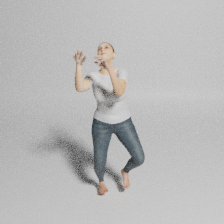

In [77]:
Image.open(imgs[10])

## Action

In [8]:
import clip


In [9]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device, jit=False)  # Must set jit=False for training
clip.model.convert_weights(clip_model)  # Actually this line is unnecessary since clip by default already on float16


In [10]:
from src.utils.misc import load_model_wo_clip
from src.utils.get_model_and_data import get_model_and_data


In [11]:
import shlex
argString = '--clip_text_losses cosine --clip_image_losses cosine --pose_rep rot6d \
--lambda_vel 100 --lambda_rc 100 --lambda_rcxyz 100 \
--jointstype vertices --batch_size 20 --num_frames 60 --num_layers 8 \
--lr 0.0001 --glob --translation --no-vertstrans --latent_dim 512 --num_epochs 100 --snapshot 10 \
--device 0 \
--dataset amass \
--datapath /srv/hays-lab/scratch/sanisetty3/music_motion/MotionCLIP/data/amass_db/amass_30fps_test.pt \
--folder ./exps/my-paper-model'

parameters = parser(shlex.split(argString))
parameters['use_action_cat_as_text_labels'] = True
parameters['only_60_classes'] = True

In [12]:

model, datasets = get_model_and_data(parameters, split='vald')

state_dict = torch.load("./exps/classes-model/checkpoint_0200.pth.tar", map_location=device)
load_model_wo_clip(model, state_dict)

/srv/hays-lab/scratch/sanisetty3/music_motion/MotionCLIP/data/amass_db/amass_30fps_vald.pt
datapath used by amass is [/srv/hays-lab/scratch/sanisetty3/music_motion/MotionCLIP/data/amass_db/amass_30fps_vald.pt]
100
100


In [13]:
from src.utils.action_label_to_idx import action_label_to_idx
train_iterator = DataLoader(datasets["train"], batch_size=4,
                                shuffle=True, num_workers=0, collate_fn=collate)


In [14]:

for batch in train_iterator:
    break
for k,v in batch.items():
    try:
        batch[k] = v.to(device)
    except:
        continue

100
100
100
100


In [16]:
action_text_labels = list(action_label_to_idx.keys())
action_text_labels.sort(key=lambda x: action_label_to_idx[x])

In [17]:
texts = clip.tokenize(action_text_labels[:60]).to(model.device)
classes_text_emb = model.clip_model.encode_text(texts).float()

In [18]:
batch['all_categories']

[['stand', 't pose'],
 ['turn', 'walk'],
 ['dance'],
 ['gesture', 'hand movements', 'greet', 'wave']]

In [19]:
batch['clip_text']

['t pose', 'walk', 'dance', 'greet']

In [20]:
batch = model(batch)
texts = clip.tokenize(batch['clip_text']).to(model.device)
batch['clip_text_embed'] = model.clip_model.encode_text(texts).float()
labels = list(map(lambda x: [action_label_to_idx[cat] for cat in x], batch['all_categories']))
classes_text_emb_norm = classes_text_emb / classes_text_emb.norm(dim=-1, keepdim=True)
motion_features_norm = batch['z'] / batch['z'].norm(dim=-1, keepdim=True)
scores = motion_features_norm @ classes_text_emb_norm.t()
similarity = (100.0 * motion_features_norm @ classes_text_emb_norm.t()).softmax(dim=-1)

total_samples += similarity.shape[0]
for i in range(similarity.shape[0]):
    print("Similarity for motion ", i , labels[i], batch['clip_text'][i],   "\n")
    values, indices = similarity[i].topk(5)
    for index , value in zip(indices, values):
        print(f"{index} , {action_text_labels[:60][index]}: {100 * value.item():.2f}%")
    print("\n")

NameError: name 'total_samples' is not defined

In [75]:
labels

[[14, 5], [34], [2], [6]]

In [21]:
correct_preds_top_5, correct_preds_top_1 = 0,0
total_samples = 0
with torch.no_grad():
    for i, batch in tqdm(enumerate(train_iterator), desc="Computing batch"):
        if isinstance(batch['x'], list):
            continue
        for key in batch.keys():
            if torch.is_tensor(batch[key]):
                batch[key] = batch[key].to(parameters['device'])
        batch = model(batch)
        texts = clip.tokenize(batch['clip_text']).to(model.device)
        batch['clip_text_embed'] = model.clip_model.encode_text(texts).float()
        labels = list(map(lambda x: [action_label_to_idx[cat] for cat in x], batch['all_categories']))
        classes_text_emb_norm = classes_text_emb / classes_text_emb.norm(dim=-1, keepdim=True)
        motion_features_norm = batch['z'] / batch['z'].norm(dim=-1, keepdim=True)
        scores = motion_features_norm @ classes_text_emb_norm.t()
        similarity = (100.0 * motion_features_norm @ classes_text_emb_norm.t()).softmax(dim=-1)

        total_samples += similarity.shape[0]
        for i in range(similarity.shape[0]):
            values, indices = similarity[i].topk(5)

            # TOP-5 CHECK
            if any([gt_cat_idx in indices for gt_cat_idx in labels[i]]):
                correct_preds_top_5 += 1

            # TOP-1 CHECK
            values = values[:1]
            indices = indices[:1]
            if any([gt_cat_idx in indices for gt_cat_idx in labels[i]]):
                correct_preds_top_1 += 1

        # print(f"Current Top-5 Acc. : {100 * correct_preds_top_5 / total_samples:.2f}%")

    print(f"Top-5 Acc. : {100 * correct_preds_top_5 / total_samples:.2f}%  ({correct_preds_top_5}/{total_samples})")
    print(f"Top-1 Acc. : {100 * correct_preds_top_1 / total_samples:.2f}%  ({correct_preds_top_1}/{total_samples})")

Computing batch: 3it [00:00, 22.85it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 9it [00:00, 23.11it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 12it [00:00, 23.12it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 18it [00:00, 23.32it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 24it [00:01, 23.39it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 30it [00:01, 23.94it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 33it [00:01, 24.12it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 39it [00:01, 23.93it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 42it [00:01, 23.87it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 48it [00:02, 24.60it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 54it [00:02, 24.37it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 57it [00:02, 23.86it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 63it [00:02, 23.50it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 69it [00:02, 24.06it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 75it [00:03, 24.36it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 78it [00:03, 24.36it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 84it [00:03, 24.36it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 90it [00:03, 24.47it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 93it [00:03, 24.55it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 99it [00:04, 23.75it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 102it [00:04, 23.40it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 108it [00:04, 23.69it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 114it [00:04, 24.10it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 117it [00:04, 24.41it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 123it [00:05, 23.96it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 129it [00:05, 23.95it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 132it [00:05, 23.77it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 138it [00:05, 24.18it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 144it [00:06, 24.01it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 147it [00:06, 23.80it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 153it [00:06, 24.06it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 159it [00:06, 24.17it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 162it [00:06, 24.27it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 168it [00:07, 24.19it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 174it [00:07, 23.84it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 177it [00:07, 23.56it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 183it [00:07, 22.87it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 189it [00:07, 22.95it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 192it [00:08, 23.17it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 198it [00:08, 23.10it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 204it [00:08, 23.31it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 207it [00:08, 23.63it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 213it [00:08, 24.03it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 219it [00:09, 24.34it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 222it [00:09, 23.99it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 228it [00:09, 24.23it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 234it [00:09, 24.17it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 237it [00:09, 23.94it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 243it [00:10, 24.24it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 249it [00:10, 23.72it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 252it [00:10, 23.91it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 258it [00:10, 24.14it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 264it [00:11, 24.02it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 267it [00:11, 23.79it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 273it [00:11, 23.72it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 279it [00:11, 23.76it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 282it [00:11, 23.51it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 288it [00:12, 23.47it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 294it [00:12, 23.77it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 297it [00:12, 23.63it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 303it [00:12, 23.89it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 309it [00:12, 24.11it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 312it [00:13, 24.16it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 318it [00:13, 23.68it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 324it [00:13, 23.58it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 327it [00:13, 23.18it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 333it [00:13, 23.62it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 339it [00:14, 23.45it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 345it [00:14, 23.91it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 348it [00:14, 23.44it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 354it [00:14, 23.89it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 357it [00:14, 23.85it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 363it [00:15, 23.91it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 369it [00:15, 23.77it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 372it [00:15, 23.59it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 378it [00:15, 23.58it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 384it [00:16, 23.90it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 387it [00:16, 23.76it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 393it [00:16, 23.85it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 399it [00:16, 24.04it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 402it [00:16, 23.82it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 408it [00:17, 23.85it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 414it [00:17, 24.15it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 417it [00:17, 23.89it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 423it [00:17, 23.71it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 429it [00:18, 24.00it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 432it [00:18, 23.99it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 438it [00:18, 23.15it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 444it [00:18, 23.59it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 447it [00:18, 23.91it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 453it [00:19, 23.87it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 459it [00:19, 24.24it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 462it [00:19, 23.65it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 468it [00:19, 23.75it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 474it [00:19, 23.94it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 477it [00:20, 23.69it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 483it [00:20, 23.91it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 489it [00:20, 24.05it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 492it [00:20, 23.79it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 498it [00:20, 23.75it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 504it [00:21, 24.12it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 507it [00:21, 23.70it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 513it [00:21, 23.25it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 519it [00:21, 23.55it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 522it [00:21, 23.63it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 528it [00:22, 24.17it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 534it [00:22, 23.91it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 537it [00:22, 23.73it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 543it [00:22, 23.53it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 549it [00:23, 23.81it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 552it [00:23, 23.83it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 558it [00:23, 24.11it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 564it [00:23, 24.10it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 567it [00:23, 23.61it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 573it [00:24, 24.12it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 579it [00:24, 24.21it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 582it [00:24, 23.63it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 588it [00:24, 23.77it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 594it [00:24, 23.33it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 597it [00:25, 23.43it/s]

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


Computing batch: 602it [00:25, 23.83it/s]

100
100
100
100
100
Top-5 Acc. : 63.72%  (1354/2125)
Top-1 Acc. : 44.99%  (956/2125)


In [22]:
print(f"Top-5 Acc. : {100 * correct_preds_top_5 / total_samples:.2f}%  ({correct_preds_top_5}/{total_samples})")
print(f"Top-1 Acc. : {100 * correct_preds_top_1 / total_samples:.2f}%  ({correct_preds_top_1}/{total_samples})")

Top-5 Acc. : 63.72%  (1354/2125)
Top-1 Acc. : 44.99%  (956/2125)


In [5]:
pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [1]:
cd ..

/coc/scratch/sanisetty3/music_motion/TGM3D/music_motion


In [2]:
!gdown 1Akf0WgAwuH2fvlWbvNpif4XRqXlpznh9

Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1Akf0WgAwuH2fvlWbvNpif4XRqXlpznh9 

